In [ ]:
import multiprocessing
import torchvision
import numpy as np
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(73647)

In [ ]:
# Check if GPU avaliable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Create class to transform the train and test data and load them

In [ ]:
# Creating a class to transform training and testing data
class CIFAR10_Transformer:
  def __init__(self, batch_size):
    # Initializing dataset and setting mean and std for the data
    self.batch_size = batch_size
    self.dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
    self.mean,self.std = self.get_mean_and_std_for_dataset()
    self.cpu_count = min(multiprocessing.cpu_count(), 8)

  def get_mean_and_std_for_dataset(self):
    # Normalize data with range 0-255 over entire dataset
    data = self.dataset.data/255.0
    mean = data.mean(axis=(0, 1, 2))
    std = data.std(axis=(0, 1, 2))
    return mean,std 

  def getTrainingData(self):
    # Setting transforms for training data
    # - horizontal flips on tha training data
    # - crop random parts in the image as input data
    # - convert to tensor
    # - normalize data over mean and std values
    train_transformers = [torchvision.transforms.RandomHorizontalFlip(),
                      torchvision.transforms.RandomCrop(size=32, padding=4),
                      torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize(mean=self.mean, std=self.std)]
    trainingDataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=torchvision.transforms.Compose(train_transformers))
    return DataLoader(trainingDataset, batch_size=self.batch_size, shuffle=True, num_workers=self.cpu_count)

  def getTestingData(self):
    # Setting transforms for testing data
    # - convert to tensor
    # - normalize data over mean and std values
    test_transformers = [torchvision.transforms.ToTensor(),
                     torchvision.transforms.Normalize(mean=self.mean, std=self.std)]
    testingDataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=torchvision.transforms.Compose(test_transformers))
    return DataLoader(testingDataset, batch_size=self.batch_size, shuffle=False, num_workers=self.cpu_count)




## Create class BasicBlock to implement skip connection with conv->BN->ReLU->conv->BN->ReLU

In [ ]:
# Class definiition for a BasicBlock with a skipped connection
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, kernel, skip_kernel, stride=1, bias=True, skip_conn = False):
        super(BasicBlock, self).__init__()

        # Layer1: conv -> BN -> ReLU
        self.conv1 = nn.Conv2d(in_channels = in_planes, 
                               out_channels = planes, 
                               kernel_size=kernel[0], 
                               stride=stride, 
                               padding=kernel[1], 
                               bias=bias)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()

        # Layer2: conv -> BN -> ReLU
        self.conv2 = nn.Conv2d(in_channels = planes, 
                               out_channels = planes, 
                               kernel_size=kernel[0],
                               stride=1, 
                               padding=kernel[1], 
                               bias=bias)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()
        
        # Including a skipped connection which will help the layers of varying dimensions connect to each other
        if skip_conn:
          self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels = in_planes, 
                          out_channels = planes,
                          kernel_size=skip_kernel[0], 
                          padding=skip_kernel[1], 
                          stride=stride, 
                          bias=bias),
                nn.BatchNorm2d(planes))  
        else:
          self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Include a skipped connection
        out += self.shortcut(x)
        out = self.relu2(out)
        return out



## Create class ResNet with 4 layers containing (2,4,8,2) blocks in each

In [ ]:
# Class Definition for the ResNet defined for CIFAR-10 class
class ResNet(nn.Module):
    def __init__(self, block, channels, num_layers, kernel, skip_kernel, num_classes=10, bias=True):
        super(ResNet, self).__init__()
        self.kernel = kernel
        self.skip_kernel = skip_kernel
        self.channels = channels
        self.num_layers = num_layers

        # Initialize the 3 channels into conv->BN->ReLU
        self.layer0 = self.make_initial_layer(3,self.channels,kernel[0],kernel[1], bias)
        
        # Layer with 2 ResNet blocks, maps 32 to 32 channels 
        self.layer1 = self.make_layer(block, self.channels, 2, stride=1, bias=bias)

        # Layer with 4 ResNet blocks, maps 32 to 64 channels 
        self.layer2 = self.make_layer(block, 2*self.channels, 4, stride=2, bias=bias)

        # Layer with 8 ResNet blocks, maps 64 to 128 channels
        self.layer3 = self.make_layer(block, 2*self.channels, 8, stride=2, bias=bias)
        
        # Layer with 2 ResNet blocks, maps 128 to 256 channels
        self.layer4 = self.make_layer(block, 2*self.channels, 2, stride=2, bias=bias)
        
        # Layer to map 256 to 10 output channels
        self.linear_class_mapper = nn.Linear(self.layer4[-1].bn2.num_features, num_classes)
        
        # Layer to aggregate data
        self.avg_pool2d = nn.AvgPool2d(4)

        # Path to model file
        self.modelpath = "./mini_project_model.pt"

    def make_initial_layer(self, in_channels, out_channels, kernel_size, padding , bias):
        return nn.Sequential( nn.Conv2d(in_channels = in_channels, 
                                out_channels = out_channels, 
                                kernel_size=kernel_size,
                                stride=1, 
                                padding= padding, 
                                bias=bias),
                              nn.BatchNorm2d(out_channels),
                              nn.ReLU())

    def make_layer(self, block, planes, num_blocks, stride, bias=True):
        # Create an initial block with lesser input to higher output channels
        layer_blocks = [block(self.channels, planes,self.kernel,self.skip_kernel, stride, bias, True)]
        self.channels = planes
        # Iteratively create Subsequent blocks with equal input and output channels
        for block_iter in range(num_blocks-1):
            layer_blocks.append(block(self.channels, planes,self.kernel,self.skip_kernel, 1, bias, False)) 
        return nn.Sequential(*layer_blocks)

    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool2d(out)
        out = out.view(out.size(0), -1)
        out = self.linear_class_mapper(out)
        return out

    def saveModel(self):
        torch.save(self.state_dict(), self.modelpath)

    def loadModel(self):
        self.load_state_dict(torch.load(self.modelpath))

def mini_project_model():
    return ResNet(BasicBlock, 32, 4,kernel=(3,1),skip_kernel=(1,0), num_classes=10, bias=True)


In [ ]:

# print(summary(model, input_size=(3, 32, 32)))
# trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

## Create class to train data with chosen best loss function, optimizer and scheduler for current network training

In [ ]:
class DataTrainer():
  def __init__(self, model, device, epochs, trainLoader, testLoader):
    self.epochs = epochs
    self.global_best_accuracy = 0.0
    self.global_best_accuracy_epoch = -1
    self.learning_rate = 0.01
    self.weight_decay = 0.0001
    self.model = model
    self.training_loss = []
    self.testing_loss = []
    self.training_accuracy = []
    self.testing_accuracy = []

    self.trainLoader = trainLoader
    self.testLoader = testLoader

    self.lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
    self.optimizer = torch.optim.Adadelta(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
    self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, self.epochs, eta_min=self.learning_rate/10.0)

    self.trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

  def get_trainable_parameters(self):
    print("Total Trainable Parameters : %s"%(self.trainable_parameters))

  def check_if_model_under_budget(self, budget):
    if self.trainable_parameters > budget:
      raise Exception("Model is not under budget.")
    else:
      print("Model is under budget.")

  def training_phase(self):
    loader = self.trainLoader
    self.model.train()
    self.optimizer.zero_grad()
    total_loss_per_epoch = 0.0
    total_corrects_per_epoch = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        output = self.model(images)
        loss = self.lossFunction(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        total_loss_per_epoch += loss.item()
        total_corrects_per_epoch += torch.sum(predicted_labels == labels).float().item()
        loss.backward()
        self.optimizer.step()
    epoch_loss = total_loss_per_epoch/len(loader.dataset)
    epoch_accuracy = total_corrects_per_epoch/len(loader.dataset)
    self.scheduler.step()
    self.training_loss.append(epoch_loss)
    self.training_accuracy.append(epoch_accuracy)

  def testing_phase(self):
    loader = self.testLoader
    self.model.eval()
    total_loss_per_epoch = 0.0
    total_corrects_per_epoch = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        output = self.model(images)
        loss = self.lossFunction(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        total_loss_per_epoch += loss.item()
        total_corrects_per_epoch += torch.sum(predicted_labels == labels).float().item()

    epoch_loss = total_loss_per_epoch/len(loader.dataset)
    epoch_accuracy = total_corrects_per_epoch/len(loader.dataset)
    self.testing_loss.append(epoch_loss)
    self.testing_accuracy.append(epoch_accuracy)
    if epoch_accuracy > self.global_best_accuracy:
        self.global_best_accuracy = epoch_accuracy
        self.model.saveModel()

  def train_model(self):
      for i in tqdm(range(self.epochs)):
        self.training_phase()
        self.testing_phase()
        self.global_best_accuracy = max(self.testing_accuracy)
        self.global_best_accuracy_epoch = np.argmax(self.testing_accuracy)

        print("Training Loss: %s, Testing Loss: %s, Training Accuracy: %s, Testing Accuracy: %s"\
          %(self.training_loss[-1], self.testing_loss[-1], self.training_accuracy[-1], self.testing_accuracy[-1]))
        
  def get_highest_accuracy(self):
      print("Max Testing Accuracy: %s"%(self.global_best_accuracy))

  def plot_accuracy_and_loss_graphs(self):
      fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 10))
      train_length = len(self.training_loss)
      plot1.plot(range(train_length), self.training_loss, '-', linewidth='3', label='Training Error')
      plot1.plot(range(train_length), self.testing_loss, '-', linewidth='3', label='Testing Error')
      plot1.grid(True)
      plot1.legend()

      plot2.plot(range(train_length), self.training_accuracy, '-', linewidth='3', label='Training Accuracy')
      plot2.plot(range(train_length), self.testing_accuracy, '-', linewidth='3', label='Testing Acuracy')
      plot2.annotate('max accuracy = %s'%(self.global_best_accuracy), xy=(self.global_best_accuracy_epoch, self.global_best_accuracy), xytext=(self.global_best_accuracy_epoch, self.global_best_accuracy+0.1), arrowprops=dict())
      plot2.grid(True)
      plot2.legend()
      
      fig.savefig("./train_test_graphs.png")

## Initialize train and test data loaders, create model and train the model

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Total Trainable Parameters : 4723434
Model is under budget.


  0%|          | 1/300 [00:36<3:02:12, 36.56s/it]

Training Loss: 1.7119332600402832, Testing Loss: 1.5162906244277954, Training Accuracy: 0.35822, Testing Accuracy: 0.4463


  1%|          | 2/300 [01:11<2:55:42, 35.38s/it]

Training Loss: 1.4481517851257324, Testing Loss: 1.3526641695022583, Training Accuracy: 0.46274, Testing Accuracy: 0.5125


  1%|          | 3/300 [01:46<2:54:35, 35.27s/it]

Training Loss: 1.2769523071289062, Testing Loss: 1.240426531982422, Training Accuracy: 0.5357, Testing Accuracy: 0.5574


  1%|▏         | 4/300 [02:22<2:56:31, 35.78s/it]

Training Loss: 1.1232152424621582, Testing Loss: 1.2404562581062317, Training Accuracy: 0.59386, Testing Accuracy: 0.5852


  2%|▏         | 5/300 [02:57<2:54:39, 35.52s/it]

Training Loss: 1.0070994409179688, Testing Loss: 1.0220359667778016, Training Accuracy: 0.64014, Testing Accuracy: 0.6448


  2%|▏         | 6/300 [03:32<2:52:55, 35.29s/it]

Training Loss: 0.9039257038879395, Testing Loss: 0.9774121477127076, Training Accuracy: 0.68002, Testing Accuracy: 0.6615


  2%|▏         | 7/300 [04:08<2:53:00, 35.43s/it]

Training Loss: 0.8363448652648926, Testing Loss: 0.8646483474731446, Training Accuracy: 0.70468, Testing Accuracy: 0.695


  3%|▎         | 8/300 [04:44<2:53:07, 35.57s/it]

Training Loss: 0.7679881829071045, Testing Loss: 0.8091448046684265, Training Accuracy: 0.729, Testing Accuracy: 0.7189


  3%|▎         | 9/300 [05:18<2:50:14, 35.10s/it]

Training Loss: 0.716818450088501, Testing Loss: 0.7730401418685913, Training Accuracy: 0.74782, Testing Accuracy: 0.7333


  3%|▎         | 10/300 [05:53<2:50:22, 35.25s/it]

Training Loss: 0.669969751663208, Testing Loss: 0.7371772757053375, Training Accuracy: 0.7653, Testing Accuracy: 0.7467


  4%|▎         | 11/300 [06:29<2:50:16, 35.35s/it]

Training Loss: 0.6334641828918457, Testing Loss: 0.6860688485145569, Training Accuracy: 0.77984, Testing Accuracy: 0.7613


  4%|▍         | 12/300 [07:04<2:48:27, 35.09s/it]

Training Loss: 0.5880501090240479, Testing Loss: 0.6390300850868225, Training Accuracy: 0.79432, Testing Accuracy: 0.781


  4%|▍         | 13/300 [07:39<2:47:52, 35.10s/it]

Training Loss: 0.5620139339447021, Testing Loss: 0.655981729221344, Training Accuracy: 0.80526, Testing Accuracy: 0.778


  5%|▍         | 14/300 [08:15<2:48:36, 35.37s/it]

Training Loss: 0.5405151942443848, Testing Loss: 0.6208939298629761, Training Accuracy: 0.81078, Testing Accuracy: 0.7847


  5%|▌         | 15/300 [08:50<2:47:34, 35.28s/it]

Training Loss: 0.5186451095581055, Testing Loss: 0.5850540183067322, Training Accuracy: 0.82042, Testing Accuracy: 0.7997


  5%|▌         | 16/300 [09:25<2:46:29, 35.17s/it]

Training Loss: 0.5006439600372314, Testing Loss: 0.5407544193267823, Training Accuracy: 0.82774, Testing Accuracy: 0.8157


  6%|▌         | 17/300 [09:59<2:44:37, 34.90s/it]

Training Loss: 0.46543384574890134, Testing Loss: 0.5400062603473663, Training Accuracy: 0.8398, Testing Accuracy: 0.8202


  6%|▌         | 18/300 [10:34<2:44:23, 34.98s/it]

Training Loss: 0.44116654556274415, Testing Loss: 0.5418094543457032, Training Accuracy: 0.84648, Testing Accuracy: 0.8178


  6%|▋         | 19/300 [11:10<2:44:26, 35.11s/it]

Training Loss: 0.44201338428497317, Testing Loss: 0.5474811040401458, Training Accuracy: 0.84732, Testing Accuracy: 0.8155


  7%|▋         | 20/300 [11:44<2:42:42, 34.87s/it]

Training Loss: 0.43274157402038577, Testing Loss: 0.5113899134635925, Training Accuracy: 0.84968, Testing Accuracy: 0.832


  7%|▋         | 21/300 [12:19<2:42:57, 35.04s/it]

Training Loss: 0.3973265510177612, Testing Loss: 0.5049626850128174, Training Accuracy: 0.86256, Testing Accuracy: 0.8299


  7%|▋         | 22/300 [12:55<2:43:00, 35.18s/it]

Training Loss: 0.3886694297790527, Testing Loss: 0.4975086566925049, Training Accuracy: 0.8649, Testing Accuracy: 0.8373


  8%|▊         | 23/300 [13:29<2:40:45, 34.82s/it]

Training Loss: 0.3693661061859131, Testing Loss: 0.4842266669273376, Training Accuracy: 0.8727, Testing Accuracy: 0.8413


  8%|▊         | 24/300 [14:04<2:41:00, 35.00s/it]

Training Loss: 0.3535570143508911, Testing Loss: 0.5213765034675598, Training Accuracy: 0.87706, Testing Accuracy: 0.8375


  8%|▊         | 25/300 [14:39<2:39:45, 34.86s/it]

Training Loss: 0.3407477290725708, Testing Loss: 0.48579243507385256, Training Accuracy: 0.88148, Testing Accuracy: 0.838


  9%|▊         | 26/300 [15:14<2:39:42, 34.97s/it]

Training Loss: 0.32774680534362793, Testing Loss: 0.47211446619033814, Training Accuracy: 0.8853, Testing Accuracy: 0.848


  9%|▉         | 27/300 [15:49<2:39:38, 35.08s/it]

Training Loss: 0.3107768803596497, Testing Loss: 0.45338522663116454, Training Accuracy: 0.89094, Testing Accuracy: 0.8508


  9%|▉         | 28/300 [16:24<2:38:41, 35.01s/it]

Training Loss: 0.30890838623046873, Testing Loss: 0.45563512859344485, Training Accuracy: 0.89316, Testing Accuracy: 0.8525


 10%|▉         | 29/300 [17:00<2:39:19, 35.27s/it]

Training Loss: 0.30652644166946413, Testing Loss: 0.45306523942947385, Training Accuracy: 0.89292, Testing Accuracy: 0.8526


 10%|█         | 30/300 [17:36<2:39:22, 35.42s/it]

Training Loss: 0.2943181805610657, Testing Loss: 0.44634640674591064, Training Accuracy: 0.8976, Testing Accuracy: 0.8594


 10%|█         | 31/300 [18:10<2:37:26, 35.12s/it]

Training Loss: 0.2790348667144775, Testing Loss: 0.4720419089317322, Training Accuracy: 0.90092, Testing Accuracy: 0.8564


 11%|█         | 32/300 [18:46<2:38:01, 35.38s/it]

Training Loss: 0.27318922618865965, Testing Loss: 0.4535585283279419, Training Accuracy: 0.90426, Testing Accuracy: 0.8593


 11%|█         | 33/300 [19:23<2:39:12, 35.78s/it]

Training Loss: 0.27063969284057615, Testing Loss: 0.4377373896121979, Training Accuracy: 0.90424, Testing Accuracy: 0.8621


 11%|█▏        | 34/300 [19:57<2:36:33, 35.31s/it]

Training Loss: 0.2526558636856079, Testing Loss: 0.4393654802799225, Training Accuracy: 0.91052, Testing Accuracy: 0.8646


 12%|█▏        | 35/300 [20:33<2:37:23, 35.64s/it]

Training Loss: 0.2522508918762207, Testing Loss: 0.46160819990634916, Training Accuracy: 0.91104, Testing Accuracy: 0.859


 12%|█▏        | 36/300 [21:10<2:37:51, 35.88s/it]

Training Loss: 0.24261621520996093, Testing Loss: 0.4276320426940918, Training Accuracy: 0.91458, Testing Accuracy: 0.8638


 12%|█▏        | 37/300 [21:44<2:35:04, 35.38s/it]

Training Loss: 0.23444415565490723, Testing Loss: 0.44636856579780576, Training Accuracy: 0.9181, Testing Accuracy: 0.8662


 13%|█▎        | 38/300 [22:20<2:35:34, 35.63s/it]

Training Loss: 0.2284926570892334, Testing Loss: 0.41084636096954347, Training Accuracy: 0.91918, Testing Accuracy: 0.8683


 13%|█▎        | 39/300 [22:57<2:36:06, 35.89s/it]

Training Loss: 0.22905508213043213, Testing Loss: 0.4305826642990112, Training Accuracy: 0.91976, Testing Accuracy: 0.8729


 13%|█▎        | 40/300 [23:31<2:33:25, 35.41s/it]

Training Loss: 0.20359022840499877, Testing Loss: 0.4061296474456787, Training Accuracy: 0.92912, Testing Accuracy: 0.878


 14%|█▎        | 41/300 [24:07<2:33:56, 35.66s/it]

Training Loss: 0.20411230104446412, Testing Loss: 0.40857667512893675, Training Accuracy: 0.9263, Testing Accuracy: 0.8772


 14%|█▍        | 42/300 [24:44<2:34:28, 35.92s/it]

Training Loss: 0.1933583299446106, Testing Loss: 0.40922344360351565, Training Accuracy: 0.93218, Testing Accuracy: 0.8785


 14%|█▍        | 43/300 [25:18<2:31:36, 35.39s/it]

Training Loss: 0.19289439059257507, Testing Loss: 0.41628726379871367, Training Accuracy: 0.9326, Testing Accuracy: 0.8752


 15%|█▍        | 44/300 [25:54<2:31:58, 35.62s/it]

Training Loss: 0.19058839247703552, Testing Loss: 0.4417692008972168, Training Accuracy: 0.9326, Testing Accuracy: 0.8731


 15%|█▌        | 45/300 [26:31<2:32:18, 35.84s/it]

Training Loss: 0.18651699460983276, Testing Loss: 0.42915158214569094, Training Accuracy: 0.93432, Testing Accuracy: 0.8745


 15%|█▌        | 46/300 [27:05<2:29:52, 35.40s/it]

Training Loss: 0.17533376804351808, Testing Loss: 0.42299641199111937, Training Accuracy: 0.938, Testing Accuracy: 0.8861


 16%|█▌        | 47/300 [27:41<2:30:14, 35.63s/it]

Training Loss: 0.1675923636817932, Testing Loss: 0.4000799504518509, Training Accuracy: 0.94062, Testing Accuracy: 0.8834


 16%|█▌        | 48/300 [28:18<2:30:49, 35.91s/it]

Training Loss: 0.16736154589653016, Testing Loss: 0.4055590141296387, Training Accuracy: 0.94138, Testing Accuracy: 0.8846


 16%|█▋        | 49/300 [28:52<2:28:01, 35.38s/it]

Training Loss: 0.16544787728309632, Testing Loss: 0.4186901360988617, Training Accuracy: 0.94188, Testing Accuracy: 0.8809


 17%|█▋        | 50/300 [29:28<2:28:26, 35.63s/it]

Training Loss: 0.15880053049087525, Testing Loss: 0.38486631336212157, Training Accuracy: 0.94208, Testing Accuracy: 0.8909


 17%|█▋        | 51/300 [30:04<2:28:50, 35.86s/it]

Training Loss: 0.1530607949733734, Testing Loss: 0.43704682154655455, Training Accuracy: 0.94644, Testing Accuracy: 0.8788


 17%|█▋        | 52/300 [30:39<2:26:50, 35.53s/it]

Training Loss: 0.14985767234802247, Testing Loss: 0.38661024618148804, Training Accuracy: 0.94604, Testing Accuracy: 0.8935


 18%|█▊        | 53/300 [31:15<2:27:03, 35.72s/it]

Training Loss: 0.14379322269439698, Testing Loss: 0.4434532328605652, Training Accuracy: 0.949, Testing Accuracy: 0.8873


 18%|█▊        | 54/300 [31:51<2:25:54, 35.59s/it]

Training Loss: 0.1472780532026291, Testing Loss: 0.42538393096923827, Training Accuracy: 0.94838, Testing Accuracy: 0.8836


 18%|█▊        | 55/300 [32:25<2:24:12, 35.32s/it]

Training Loss: 0.1316523621559143, Testing Loss: 0.42005372762680054, Training Accuracy: 0.95352, Testing Accuracy: 0.8901


 19%|█▊        | 56/300 [33:01<2:24:03, 35.42s/it]

Training Loss: 0.13294659613609314, Testing Loss: 0.4336931510925293, Training Accuracy: 0.95326, Testing Accuracy: 0.8861


 19%|█▉        | 57/300 [33:35<2:21:44, 35.00s/it]

Training Loss: 0.12809067761421203, Testing Loss: 0.4176905721664429, Training Accuracy: 0.95432, Testing Accuracy: 0.8931


 19%|█▉        | 58/300 [34:11<2:21:52, 35.18s/it]

Training Loss: 0.12101562119483948, Testing Loss: 0.4086101999759674, Training Accuracy: 0.95698, Testing Accuracy: 0.8916


 20%|█▉        | 59/300 [34:46<2:21:41, 35.27s/it]

Training Loss: 0.12134067785263061, Testing Loss: 0.4421280527114868, Training Accuracy: 0.95836, Testing Accuracy: 0.888


 20%|██        | 60/300 [35:20<2:19:31, 34.88s/it]

Training Loss: 0.11220984791755677, Testing Loss: 0.43850231714248655, Training Accuracy: 0.96, Testing Accuracy: 0.8897


 20%|██        | 61/300 [35:55<2:19:27, 35.01s/it]

Training Loss: 0.11855984787464142, Testing Loss: 0.418811830329895, Training Accuracy: 0.95732, Testing Accuracy: 0.8904


 21%|██        | 62/300 [36:31<2:19:29, 35.17s/it]

Training Loss: 0.10734946702003478, Testing Loss: 0.4362852717876434, Training Accuracy: 0.9613, Testing Accuracy: 0.8921


 21%|██        | 63/300 [37:06<2:18:31, 35.07s/it]

Training Loss: 0.10501183806419373, Testing Loss: 0.41868144226074216, Training Accuracy: 0.9627, Testing Accuracy: 0.8929


 21%|██▏       | 64/300 [37:40<2:17:24, 34.93s/it]

Training Loss: 0.10466782918453217, Testing Loss: 0.4579638414859772, Training Accuracy: 0.9632, Testing Accuracy: 0.8915


 22%|██▏       | 65/300 [38:16<2:17:14, 35.04s/it]

Training Loss: 0.11271372821331024, Testing Loss: 0.43530858001708983, Training Accuracy: 0.95958, Testing Accuracy: 0.8852


 22%|██▏       | 66/300 [38:50<2:16:06, 34.90s/it]

Training Loss: 0.1029632603263855, Testing Loss: 0.4238645887374878, Training Accuracy: 0.96442, Testing Accuracy: 0.8977


 22%|██▏       | 67/300 [39:25<2:15:26, 34.88s/it]

Training Loss: 0.09068367527723313, Testing Loss: 0.4536487052440643, Training Accuracy: 0.96768, Testing Accuracy: 0.8922


 23%|██▎       | 68/300 [40:01<2:15:42, 35.10s/it]

Training Loss: 0.10187966017723084, Testing Loss: 0.4121912799835205, Training Accuracy: 0.96438, Testing Accuracy: 0.8917


 23%|██▎       | 69/300 [40:35<2:14:37, 34.97s/it]

Training Loss: 0.0890412381696701, Testing Loss: 0.4438377806663513, Training Accuracy: 0.96972, Testing Accuracy: 0.8931


 23%|██▎       | 70/300 [41:11<2:15:04, 35.24s/it]

Training Loss: 0.09078953496694565, Testing Loss: 0.4724411497116089, Training Accuracy: 0.96798, Testing Accuracy: 0.8901


 24%|██▎       | 71/300 [41:46<2:14:04, 35.13s/it]

Training Loss: 0.09217178926467895, Testing Loss: 0.43013884935379026, Training Accuracy: 0.96704, Testing Accuracy: 0.8947


 24%|██▍       | 72/300 [42:21<2:13:18, 35.08s/it]

Training Loss: 0.0875219343996048, Testing Loss: 0.4293007899284363, Training Accuracy: 0.96982, Testing Accuracy: 0.8993


 24%|██▍       | 73/300 [42:56<2:12:28, 35.01s/it]

Training Loss: 0.08143346237659455, Testing Loss: 0.4409630214691162, Training Accuracy: 0.97164, Testing Accuracy: 0.8949


 25%|██▍       | 74/300 [43:31<2:11:27, 34.90s/it]

Training Loss: 0.08125477877378463, Testing Loss: 0.4451785891532898, Training Accuracy: 0.97108, Testing Accuracy: 0.8946


 25%|██▌       | 75/300 [44:06<2:11:18, 35.02s/it]

Training Loss: 0.0744361216878891, Testing Loss: 0.42632720766067506, Training Accuracy: 0.97416, Testing Accuracy: 0.9031


 25%|██▌       | 76/300 [44:42<2:11:48, 35.31s/it]

Training Loss: 0.075455935100317, Testing Loss: 0.4379411956787109, Training Accuracy: 0.97278, Testing Accuracy: 0.9014


 26%|██▌       | 77/300 [45:16<2:09:43, 34.90s/it]

Training Loss: 0.07747148855447769, Testing Loss: 0.4393127431869507, Training Accuracy: 0.97256, Testing Accuracy: 0.8985


 26%|██▌       | 78/300 [45:51<2:09:50, 35.09s/it]

Training Loss: 0.07483757177591324, Testing Loss: 0.44366141755878924, Training Accuracy: 0.97322, Testing Accuracy: 0.9


 26%|██▋       | 79/300 [46:27<2:09:44, 35.23s/it]

Training Loss: 0.0751416910815239, Testing Loss: 0.45987791470885275, Training Accuracy: 0.97344, Testing Accuracy: 0.896


 27%|██▋       | 80/300 [47:01<2:07:48, 34.86s/it]

Training Loss: 0.07719529528617859, Testing Loss: 0.43349572048187257, Training Accuracy: 0.97246, Testing Accuracy: 0.8996


 27%|██▋       | 81/300 [47:36<2:07:47, 35.01s/it]

Training Loss: 0.06979037981510162, Testing Loss: 0.4206403673648834, Training Accuracy: 0.97524, Testing Accuracy: 0.8993


 27%|██▋       | 82/300 [48:11<2:07:31, 35.10s/it]

Training Loss: 0.06584728442668915, Testing Loss: 0.45016061840057375, Training Accuracy: 0.9768, Testing Accuracy: 0.9008


 28%|██▊       | 83/300 [48:46<2:06:37, 35.01s/it]

Training Loss: 0.06709878130674363, Testing Loss: 0.45135035090446474, Training Accuracy: 0.97582, Testing Accuracy: 0.8993


 28%|██▊       | 84/300 [49:21<2:05:42, 34.92s/it]

Training Loss: 0.06679905883312226, Testing Loss: 0.4704955330848694, Training Accuracy: 0.97658, Testing Accuracy: 0.8988


 28%|██▊       | 85/300 [49:57<2:05:53, 35.13s/it]

Training Loss: 0.06586137517213822, Testing Loss: 0.45006831035614014, Training Accuracy: 0.97602, Testing Accuracy: 0.8982


 29%|██▊       | 86/300 [50:31<2:04:52, 35.01s/it]

Training Loss: 0.0645507152891159, Testing Loss: 0.46811192512512206, Training Accuracy: 0.97758, Testing Accuracy: 0.9008


 29%|██▉       | 87/300 [51:07<2:04:39, 35.12s/it]

Training Loss: 0.05748438864827156, Testing Loss: 0.4662485132217407, Training Accuracy: 0.97934, Testing Accuracy: 0.9023


 29%|██▉       | 88/300 [51:41<2:02:52, 34.78s/it]

Training Loss: 0.06215727642416954, Testing Loss: 0.45166915073394776, Training Accuracy: 0.97794, Testing Accuracy: 0.8991


 30%|██▉       | 89/300 [52:16<2:03:02, 34.99s/it]

Training Loss: 0.058620100215673446, Testing Loss: 0.4653825850486755, Training Accuracy: 0.97896, Testing Accuracy: 0.9042


 30%|███       | 90/300 [52:51<2:02:24, 34.97s/it]

Training Loss: 0.052026010780334475, Testing Loss: 0.45492844009399414, Training Accuracy: 0.98158, Testing Accuracy: 0.9045


 30%|███       | 91/300 [53:26<2:01:22, 34.85s/it]

Training Loss: 0.053814442704916, Testing Loss: 0.4767613832473755, Training Accuracy: 0.98108, Testing Accuracy: 0.9013


 31%|███       | 92/300 [54:01<2:01:42, 35.11s/it]

Training Loss: 0.05649478628158569, Testing Loss: 0.4876718199729919, Training Accuracy: 0.98092, Testing Accuracy: 0.9041


 31%|███       | 93/300 [54:36<2:00:57, 35.06s/it]

Training Loss: 0.05483617360085249, Testing Loss: 0.4888857116699219, Training Accuracy: 0.98124, Testing Accuracy: 0.9005


 31%|███▏      | 94/300 [55:11<1:59:56, 34.94s/it]

Training Loss: 0.051281954218149184, Testing Loss: 0.4768713701248169, Training Accuracy: 0.98222, Testing Accuracy: 0.9031


 32%|███▏      | 95/300 [55:47<2:00:29, 35.27s/it]

Training Loss: 0.052090288895368576, Testing Loss: 0.4462282901763916, Training Accuracy: 0.98108, Testing Accuracy: 0.9119


 32%|███▏      | 96/300 [56:22<1:59:26, 35.13s/it]

Training Loss: 0.044069971151947974, Testing Loss: 0.476985196018219, Training Accuracy: 0.98518, Testing Accuracy: 0.9069


 32%|███▏      | 97/300 [56:56<1:58:22, 34.99s/it]

Training Loss: 0.04723079115986824, Testing Loss: 0.4410763536453247, Training Accuracy: 0.9834, Testing Accuracy: 0.9105


 33%|███▎      | 98/300 [57:31<1:57:34, 34.92s/it]

Training Loss: 0.04817231241345406, Testing Loss: 0.5046295177459716, Training Accuracy: 0.98312, Testing Accuracy: 0.9021


 33%|███▎      | 99/300 [58:07<1:57:51, 35.18s/it]

Training Loss: 0.045990096725821494, Testing Loss: 0.4579515880584717, Training Accuracy: 0.98414, Testing Accuracy: 0.9082


 33%|███▎      | 100/300 [58:42<1:56:57, 35.09s/it]

Training Loss: 0.04866148097991943, Testing Loss: 0.47183704261779785, Training Accuracy: 0.98288, Testing Accuracy: 0.9039


 34%|███▎      | 101/300 [59:16<1:55:06, 34.71s/it]

Training Loss: 0.04960923654317856, Testing Loss: 0.45984702377319336, Training Accuracy: 0.98228, Testing Accuracy: 0.9057


 34%|███▍      | 102/300 [59:51<1:54:53, 34.82s/it]

Training Loss: 0.042911190361976624, Testing Loss: 0.472544543838501, Training Accuracy: 0.98546, Testing Accuracy: 0.9092


 34%|███▍      | 103/300 [1:00:25<1:53:56, 34.70s/it]

Training Loss: 0.042531998130083085, Testing Loss: 0.5096900609016418, Training Accuracy: 0.98494, Testing Accuracy: 0.9031


 35%|███▍      | 104/300 [1:01:00<1:53:39, 34.79s/it]

Training Loss: 0.047136750631332394, Testing Loss: 0.4749312774658203, Training Accuracy: 0.98412, Testing Accuracy: 0.9026


 35%|███▌      | 105/300 [1:01:35<1:52:38, 34.66s/it]

Training Loss: 0.04016721404016018, Testing Loss: 0.4701996356010437, Training Accuracy: 0.98628, Testing Accuracy: 0.9081


 35%|███▌      | 106/300 [1:02:10<1:52:28, 34.79s/it]

Training Loss: 0.041683208432495594, Testing Loss: 0.47910415711402893, Training Accuracy: 0.98524, Testing Accuracy: 0.9077


 36%|███▌      | 107/300 [1:02:44<1:51:51, 34.77s/it]

Training Loss: 0.04804820079922676, Testing Loss: 0.5390547468185425, Training Accuracy: 0.98318, Testing Accuracy: 0.897


 36%|███▌      | 108/300 [1:03:19<1:50:42, 34.60s/it]

Training Loss: 0.047881796568632125, Testing Loss: 0.4950892988204956, Training Accuracy: 0.9834, Testing Accuracy: 0.9007


 36%|███▋      | 109/300 [1:03:54<1:51:01, 34.87s/it]

Training Loss: 0.053751021296977994, Testing Loss: 0.5175252646446228, Training Accuracy: 0.98116, Testing Accuracy: 0.8994


 37%|███▋      | 110/300 [1:04:29<1:50:09, 34.79s/it]

Training Loss: 0.04506906560301781, Testing Loss: 0.5042059370040893, Training Accuracy: 0.98408, Testing Accuracy: 0.9052


 37%|███▋      | 111/300 [1:05:03<1:49:10, 34.66s/it]

Training Loss: 0.04028872788488865, Testing Loss: 0.45710160045623777, Training Accuracy: 0.9861, Testing Accuracy: 0.9097


 37%|███▋      | 112/300 [1:05:38<1:49:00, 34.79s/it]

Training Loss: 0.0359173823350668, Testing Loss: 0.5008144733428955, Training Accuracy: 0.98752, Testing Accuracy: 0.9058


 38%|███▊      | 113/300 [1:06:14<1:49:29, 35.13s/it]

Training Loss: 0.0330811631283164, Testing Loss: 0.4632022310256958, Training Accuracy: 0.98816, Testing Accuracy: 0.9121


 38%|███▊      | 114/300 [1:06:48<1:47:38, 34.72s/it]

Training Loss: 0.03411204537451267, Testing Loss: 0.48597492809295656, Training Accuracy: 0.98796, Testing Accuracy: 0.911


 38%|███▊      | 115/300 [1:07:23<1:47:36, 34.90s/it]

Training Loss: 0.03359353635460138, Testing Loss: 0.5083713157653809, Training Accuracy: 0.9884, Testing Accuracy: 0.9086


 39%|███▊      | 116/300 [1:07:59<1:47:42, 35.12s/it]

Training Loss: 0.03473663069337606, Testing Loss: 0.5175471885681152, Training Accuracy: 0.98776, Testing Accuracy: 0.9071


 39%|███▉      | 117/300 [1:08:33<1:45:54, 34.72s/it]

Training Loss: 0.034795362747609616, Testing Loss: 0.4927834764480591, Training Accuracy: 0.9881, Testing Accuracy: 0.9086


 39%|███▉      | 118/300 [1:09:08<1:46:01, 34.95s/it]

Training Loss: 0.03399709342360496, Testing Loss: 0.5170533690940589, Training Accuracy: 0.98828, Testing Accuracy: 0.9073


 40%|███▉      | 119/300 [1:09:43<1:45:23, 34.94s/it]

Training Loss: 0.03543573441505432, Testing Loss: 0.5267203466415405, Training Accuracy: 0.98792, Testing Accuracy: 0.9051


 40%|████      | 120/300 [1:10:18<1:44:32, 34.85s/it]

Training Loss: 0.03754675374388695, Testing Loss: 0.5076563351631165, Training Accuracy: 0.98722, Testing Accuracy: 0.9054


 40%|████      | 121/300 [1:10:53<1:44:14, 34.94s/it]

Training Loss: 0.03333414345830679, Testing Loss: 0.4650170407295227, Training Accuracy: 0.98858, Testing Accuracy: 0.9126


 41%|████      | 122/300 [1:11:27<1:43:24, 34.85s/it]

Training Loss: 0.028455005864501, Testing Loss: 0.5056244960784912, Training Accuracy: 0.99008, Testing Accuracy: 0.911


 41%|████      | 123/300 [1:12:03<1:43:25, 35.06s/it]

Training Loss: 0.02870191966354847, Testing Loss: 0.4669307577133179, Training Accuracy: 0.98992, Testing Accuracy: 0.909


 41%|████▏     | 124/300 [1:12:38<1:42:34, 34.97s/it]

Training Loss: 0.028202063886374234, Testing Loss: 0.5027146938323974, Training Accuracy: 0.99054, Testing Accuracy: 0.9082


 42%|████▏     | 125/300 [1:13:12<1:41:37, 34.84s/it]

Training Loss: 0.026936321192979812, Testing Loss: 0.5315351049900054, Training Accuracy: 0.99064, Testing Accuracy: 0.9077


 42%|████▏     | 126/300 [1:13:48<1:41:26, 34.98s/it]

Training Loss: 0.033806433800160886, Testing Loss: 0.5199353803634643, Training Accuracy: 0.98802, Testing Accuracy: 0.9107


 42%|████▏     | 127/300 [1:14:23<1:41:28, 35.19s/it]

Training Loss: 0.03152897232621908, Testing Loss: 0.5207222188949585, Training Accuracy: 0.9892, Testing Accuracy: 0.9126


 43%|████▎     | 128/300 [1:14:57<1:39:38, 34.76s/it]

Training Loss: 0.025758594190478323, Testing Loss: 0.5066586941719056, Training Accuracy: 0.99122, Testing Accuracy: 0.9109


 43%|████▎     | 129/300 [1:15:33<1:39:41, 34.98s/it]

Training Loss: 0.024425742328613997, Testing Loss: 0.5180531397819519, Training Accuracy: 0.99174, Testing Accuracy: 0.9133


 43%|████▎     | 130/300 [1:16:07<1:39:04, 34.97s/it]

Training Loss: 0.02463540438890457, Testing Loss: 0.509007608795166, Training Accuracy: 0.99164, Testing Accuracy: 0.9127


 44%|████▎     | 131/300 [1:16:42<1:38:04, 34.82s/it]

Training Loss: 0.025572476550340652, Testing Loss: 0.5190857617855072, Training Accuracy: 0.99136, Testing Accuracy: 0.9111


 44%|████▍     | 132/300 [1:17:17<1:38:03, 35.02s/it]

Training Loss: 0.0243068241520226, Testing Loss: 0.5130057991981506, Training Accuracy: 0.99146, Testing Accuracy: 0.9147


 44%|████▍     | 133/300 [1:17:52<1:37:08, 34.90s/it]

Training Loss: 0.02042919361025095, Testing Loss: 0.5362158694267273, Training Accuracy: 0.99308, Testing Accuracy: 0.9146


 45%|████▍     | 134/300 [1:18:28<1:37:13, 35.14s/it]

Training Loss: 0.02456678655490279, Testing Loss: 0.5115508609771728, Training Accuracy: 0.99156, Testing Accuracy: 0.9102


 45%|████▌     | 135/300 [1:19:03<1:36:24, 35.06s/it]

Training Loss: 0.025669254399985075, Testing Loss: 0.508499251461029, Training Accuracy: 0.99116, Testing Accuracy: 0.9112


 45%|████▌     | 136/300 [1:19:37<1:35:37, 34.98s/it]

Training Loss: 0.02182939391106367, Testing Loss: 0.4997875774383545, Training Accuracy: 0.99224, Testing Accuracy: 0.9138


 46%|████▌     | 137/300 [1:20:13<1:35:40, 35.22s/it]

Training Loss: 0.021579505247622727, Testing Loss: 0.5297146275520325, Training Accuracy: 0.99244, Testing Accuracy: 0.9115


 46%|████▌     | 138/300 [1:20:48<1:34:42, 35.08s/it]

Training Loss: 0.023736267954409123, Testing Loss: 0.5187209476470948, Training Accuracy: 0.99146, Testing Accuracy: 0.9095


 46%|████▋     | 139/300 [1:21:23<1:33:56, 35.01s/it]

Training Loss: 0.024007339307516813, Testing Loss: 0.5039762078285217, Training Accuracy: 0.99168, Testing Accuracy: 0.9159


 47%|████▋     | 140/300 [1:21:58<1:33:45, 35.16s/it]

Training Loss: 0.02011681193098426, Testing Loss: 0.50130505027771, Training Accuracy: 0.99304, Testing Accuracy: 0.9145


 47%|████▋     | 141/300 [1:22:33<1:33:05, 35.13s/it]

Training Loss: 0.02086647989988327, Testing Loss: 0.5037872503280639, Training Accuracy: 0.99298, Testing Accuracy: 0.915


 47%|████▋     | 142/300 [1:23:09<1:32:33, 35.15s/it]

Training Loss: 0.01966691399253905, Testing Loss: 0.5200199604034423, Training Accuracy: 0.99286, Testing Accuracy: 0.9149


 48%|████▊     | 143/300 [1:23:44<1:32:27, 35.34s/it]

Training Loss: 0.01733612370632589, Testing Loss: 0.529768971824646, Training Accuracy: 0.9939, Testing Accuracy: 0.914


 48%|████▊     | 144/300 [1:24:19<1:31:42, 35.27s/it]

Training Loss: 0.01856682923834771, Testing Loss: 0.5193351327896119, Training Accuracy: 0.99364, Testing Accuracy: 0.9147


 48%|████▊     | 145/300 [1:24:55<1:31:06, 35.27s/it]

Training Loss: 0.016581579706966876, Testing Loss: 0.537207910823822, Training Accuracy: 0.9941, Testing Accuracy: 0.9147


 49%|████▊     | 146/300 [1:25:30<1:30:34, 35.29s/it]

Training Loss: 0.01970904491648078, Testing Loss: 0.5462561407089234, Training Accuracy: 0.9932, Testing Accuracy: 0.9134


 49%|████▉     | 147/300 [1:26:05<1:29:27, 35.08s/it]

Training Loss: 0.022014650128483772, Testing Loss: 0.5614360805988312, Training Accuracy: 0.9925, Testing Accuracy: 0.9087


 49%|████▉     | 148/300 [1:26:40<1:29:11, 35.21s/it]

Training Loss: 0.022866664916127922, Testing Loss: 0.5279698892593384, Training Accuracy: 0.99198, Testing Accuracy: 0.9128


 50%|████▉     | 149/300 [1:27:15<1:28:07, 35.02s/it]

Training Loss: 0.01721376620132476, Testing Loss: 0.5415178999900818, Training Accuracy: 0.99436, Testing Accuracy: 0.9109


 50%|█████     | 150/300 [1:27:49<1:27:18, 34.92s/it]

Training Loss: 0.015020925543829798, Testing Loss: 0.5626465925693512, Training Accuracy: 0.99476, Testing Accuracy: 0.9121


 50%|█████     | 151/300 [1:28:25<1:27:03, 35.06s/it]

Training Loss: 0.018713952639941127, Testing Loss: 0.5595728244781494, Training Accuracy: 0.99346, Testing Accuracy: 0.9082


 51%|█████     | 152/300 [1:28:58<1:25:26, 34.64s/it]

Training Loss: 0.019755934426784517, Testing Loss: 0.5697130495548248, Training Accuracy: 0.9933, Testing Accuracy: 0.9134


 51%|█████     | 153/300 [1:29:34<1:25:33, 34.92s/it]

Training Loss: 0.019413910650014878, Testing Loss: 0.5347103883743286, Training Accuracy: 0.9933, Testing Accuracy: 0.9149


 51%|█████▏    | 154/300 [1:30:10<1:25:40, 35.21s/it]

Training Loss: 0.014968842043802142, Testing Loss: 0.5297193000793458, Training Accuracy: 0.99468, Testing Accuracy: 0.9168


 52%|█████▏    | 155/300 [1:30:44<1:24:01, 34.77s/it]

Training Loss: 0.014710596187785268, Testing Loss: 0.5316479978561401, Training Accuracy: 0.995, Testing Accuracy: 0.9163


 52%|█████▏    | 156/300 [1:31:19<1:23:49, 34.92s/it]

Training Loss: 0.01330681864142418, Testing Loss: 0.5417410207748413, Training Accuracy: 0.9955, Testing Accuracy: 0.9148


 52%|█████▏    | 157/300 [1:31:54<1:23:26, 35.01s/it]

Training Loss: 0.017496034677363933, Testing Loss: 0.5162297091484069, Training Accuracy: 0.99398, Testing Accuracy: 0.9177


 53%|█████▎    | 158/300 [1:32:29<1:22:22, 34.81s/it]

Training Loss: 0.01408294265717268, Testing Loss: 0.5315638735443353, Training Accuracy: 0.9953, Testing Accuracy: 0.9161


 53%|█████▎    | 159/300 [1:33:04<1:21:56, 34.87s/it]

Training Loss: 0.01181985467672348, Testing Loss: 0.5814300182342529, Training Accuracy: 0.9958, Testing Accuracy: 0.9141


 53%|█████▎    | 160/300 [1:33:39<1:21:59, 35.14s/it]

Training Loss: 0.014551598264500499, Testing Loss: 0.5524665287017823, Training Accuracy: 0.9947, Testing Accuracy: 0.9159


 54%|█████▎    | 161/300 [1:34:13<1:20:39, 34.81s/it]

Training Loss: 0.021471689760275185, Testing Loss: 0.551379856967926, Training Accuracy: 0.99306, Testing Accuracy: 0.9154


 54%|█████▍    | 162/300 [1:34:49<1:20:20, 34.93s/it]

Training Loss: 0.016309171747118236, Testing Loss: 0.5707482454299927, Training Accuracy: 0.9943, Testing Accuracy: 0.9142


 54%|█████▍    | 163/300 [1:35:23<1:19:44, 34.92s/it]

Training Loss: 0.01286838979229331, Testing Loss: 0.566628738117218, Training Accuracy: 0.99544, Testing Accuracy: 0.9169


 55%|█████▍    | 164/300 [1:35:59<1:19:23, 35.03s/it]

Training Loss: 0.013674572986364365, Testing Loss: 0.5661977043151856, Training Accuracy: 0.99504, Testing Accuracy: 0.9147


 55%|█████▌    | 165/300 [1:36:33<1:18:34, 34.92s/it]

Training Loss: 0.015699309696676208, Testing Loss: 0.5633909276485443, Training Accuracy: 0.99432, Testing Accuracy: 0.915


 55%|█████▌    | 166/300 [1:37:08<1:17:43, 34.80s/it]

Training Loss: 0.013468455926701426, Testing Loss: 0.5475369266152382, Training Accuracy: 0.99546, Testing Accuracy: 0.9158


 56%|█████▌    | 167/300 [1:37:43<1:17:33, 34.99s/it]

Training Loss: 0.013812931522261351, Testing Loss: 0.6179348031812347, Training Accuracy: 0.99514, Testing Accuracy: 0.9098


 56%|█████▌    | 168/300 [1:38:19<1:17:19, 35.14s/it]

Training Loss: 0.01373869010904804, Testing Loss: 0.5582966286420822, Training Accuracy: 0.99518, Testing Accuracy: 0.9133


 56%|█████▋    | 169/300 [1:38:53<1:15:53, 34.76s/it]

Training Loss: 0.01695930183209479, Testing Loss: 0.5745175467669964, Training Accuracy: 0.99454, Testing Accuracy: 0.9148


 57%|█████▋    | 170/300 [1:39:28<1:15:46, 34.98s/it]

Training Loss: 0.015330686987638474, Testing Loss: 0.527837960600853, Training Accuracy: 0.9949, Testing Accuracy: 0.9165


 57%|█████▋    | 171/300 [1:40:04<1:15:55, 35.31s/it]

Training Loss: 0.012350263772886247, Testing Loss: 0.5765611998558045, Training Accuracy: 0.99564, Testing Accuracy: 0.9167


 57%|█████▋    | 172/300 [1:40:38<1:14:22, 34.86s/it]

Training Loss: 0.012933772863596678, Testing Loss: 0.5637685120105743, Training Accuracy: 0.99564, Testing Accuracy: 0.9171


 58%|█████▊    | 173/300 [1:41:14<1:14:17, 35.10s/it]

Training Loss: 0.01545270111290738, Testing Loss: 0.5599863515853882, Training Accuracy: 0.99488, Testing Accuracy: 0.9164


 58%|█████▊    | 174/300 [1:41:49<1:13:37, 35.06s/it]

Training Loss: 0.012258625547513365, Testing Loss: 0.5649010602340102, Training Accuracy: 0.99584, Testing Accuracy: 0.9184


 58%|█████▊    | 175/300 [1:42:24<1:13:01, 35.05s/it]

Training Loss: 0.011752189797759056, Testing Loss: 0.5622267136096954, Training Accuracy: 0.99578, Testing Accuracy: 0.9159


 59%|█████▊    | 176/300 [1:42:59<1:12:24, 35.04s/it]

Training Loss: 0.013256338663967327, Testing Loss: 0.578376296043396, Training Accuracy: 0.9956, Testing Accuracy: 0.9146


 59%|█████▉    | 177/300 [1:43:33<1:11:29, 34.87s/it]

Training Loss: 0.012170665723327548, Testing Loss: 0.58440755443573, Training Accuracy: 0.99612, Testing Accuracy: 0.9141


 59%|█████▉    | 178/300 [1:44:09<1:11:19, 35.08s/it]

Training Loss: 0.012221019215397536, Testing Loss: 0.5705747035503388, Training Accuracy: 0.99584, Testing Accuracy: 0.9154


 60%|█████▉    | 179/300 [1:44:43<1:10:23, 34.90s/it]

Training Loss: 0.01089207563702017, Testing Loss: 0.5538337516784668, Training Accuracy: 0.99624, Testing Accuracy: 0.9178


 60%|██████    | 180/300 [1:45:18<1:09:36, 34.80s/it]

Training Loss: 0.010417265056334436, Testing Loss: 0.5233327456220984, Training Accuracy: 0.99628, Testing Accuracy: 0.9208


 60%|██████    | 181/300 [1:45:53<1:09:19, 34.96s/it]

Training Loss: 0.007109616850893945, Testing Loss: 0.5807398387908935, Training Accuracy: 0.99748, Testing Accuracy: 0.92


 61%|██████    | 182/300 [1:46:28<1:08:54, 35.04s/it]

Training Loss: 0.008036119422903285, Testing Loss: 0.5983986498594284, Training Accuracy: 0.99706, Testing Accuracy: 0.9171


 61%|██████    | 183/300 [1:47:03<1:08:01, 34.88s/it]

Training Loss: 0.007725816018804908, Testing Loss: 0.5966306458950043, Training Accuracy: 0.99732, Testing Accuracy: 0.9186


 61%|██████▏   | 184/300 [1:47:39<1:07:58, 35.16s/it]

Training Loss: 0.008611935833655297, Testing Loss: 0.5741297543525696, Training Accuracy: 0.99714, Testing Accuracy: 0.9181


 62%|██████▏   | 185/300 [1:48:13<1:06:49, 34.87s/it]

Training Loss: 0.009189252159697936, Testing Loss: 0.6358553444862366, Training Accuracy: 0.9967, Testing Accuracy: 0.9128


 62%|██████▏   | 186/300 [1:48:48<1:06:25, 34.96s/it]

Training Loss: 0.012196893853712826, Testing Loss: 0.6258630459275096, Training Accuracy: 0.99566, Testing Accuracy: 0.9151


 62%|██████▏   | 187/300 [1:49:23<1:06:04, 35.08s/it]

Training Loss: 0.010687693689875304, Testing Loss: 0.5815606800079346, Training Accuracy: 0.99628, Testing Accuracy: 0.9181


 63%|██████▎   | 188/300 [1:49:58<1:05:13, 34.94s/it]

Training Loss: 0.00765062375927344, Testing Loss: 0.6277367121219635, Training Accuracy: 0.99746, Testing Accuracy: 0.9161


 63%|██████▎   | 189/300 [1:50:33<1:04:21, 34.79s/it]

Training Loss: 0.010337180580347776, Testing Loss: 0.608601887512207, Training Accuracy: 0.99648, Testing Accuracy: 0.9152


 63%|██████▎   | 190/300 [1:51:08<1:04:09, 34.99s/it]

Training Loss: 0.010765308518931269, Testing Loss: 0.5794910546302795, Training Accuracy: 0.9963, Testing Accuracy: 0.9193


 64%|██████▎   | 191/300 [1:51:42<1:03:14, 34.81s/it]

Training Loss: 0.009612438170164824, Testing Loss: 0.5895809110641479, Training Accuracy: 0.99676, Testing Accuracy: 0.917


 64%|██████▍   | 192/300 [1:52:18<1:02:54, 34.95s/it]

Training Loss: 0.009706283908830956, Testing Loss: 0.5952675999641418, Training Accuracy: 0.9968, Testing Accuracy: 0.9191


 64%|██████▍   | 193/300 [1:52:51<1:01:37, 34.56s/it]

Training Loss: 0.008470991023406387, Testing Loss: 0.5576464190483094, Training Accuracy: 0.99686, Testing Accuracy: 0.9202


 65%|██████▍   | 194/300 [1:53:26<1:01:23, 34.75s/it]

Training Loss: 0.006437687507644296, Testing Loss: 0.5761635679244995, Training Accuracy: 0.99792, Testing Accuracy: 0.9204


 65%|██████▌   | 195/300 [1:54:02<1:01:06, 34.92s/it]

Training Loss: 0.005612956648394465, Testing Loss: 0.5687813212871552, Training Accuracy: 0.9981, Testing Accuracy: 0.923


 65%|██████▌   | 196/300 [1:54:35<59:50, 34.52s/it]  

Training Loss: 0.0045452670726180075, Testing Loss: 0.5916042980194092, Training Accuracy: 0.9985, Testing Accuracy: 0.9203


 66%|██████▌   | 197/300 [1:55:11<59:36, 34.72s/it]

Training Loss: 0.00493448952132836, Testing Loss: 0.6003460562705993, Training Accuracy: 0.99824, Testing Accuracy: 0.9209


 66%|██████▌   | 198/300 [1:55:46<59:24, 34.95s/it]

Training Loss: 0.005523372464245185, Testing Loss: 0.629858540725708, Training Accuracy: 0.99808, Testing Accuracy: 0.9193


 66%|██████▋   | 199/300 [1:56:20<58:10, 34.56s/it]

Training Loss: 0.0073388918708637355, Testing Loss: 0.5998837558746338, Training Accuracy: 0.9976, Testing Accuracy: 0.9219


 67%|██████▋   | 200/300 [1:56:55<58:00, 34.80s/it]

Training Loss: 0.005644168736422434, Testing Loss: 0.6192627373695374, Training Accuracy: 0.99786, Testing Accuracy: 0.9214


 67%|██████▋   | 201/300 [1:57:30<57:18, 34.73s/it]

Training Loss: 0.005487447887840681, Testing Loss: 0.6269575779914855, Training Accuracy: 0.99816, Testing Accuracy: 0.9186


 67%|██████▋   | 202/300 [1:58:05<57:01, 34.92s/it]

Training Loss: 0.007149051641440019, Testing Loss: 0.5946299777984619, Training Accuracy: 0.99756, Testing Accuracy: 0.9186


 68%|██████▊   | 203/300 [1:58:40<56:40, 35.05s/it]

Training Loss: 0.0073418777684029195, Testing Loss: 0.591055574798584, Training Accuracy: 0.99752, Testing Accuracy: 0.9221


 68%|██████▊   | 204/300 [1:59:15<55:46, 34.86s/it]

Training Loss: 0.006054494056156837, Testing Loss: 0.5890328025817871, Training Accuracy: 0.99812, Testing Accuracy: 0.9204


 68%|██████▊   | 205/300 [1:59:50<55:15, 34.90s/it]

Training Loss: 0.0049546569908969105, Testing Loss: 0.5806826807022095, Training Accuracy: 0.99848, Testing Accuracy: 0.9234


 69%|██████▊   | 206/300 [2:00:24<54:33, 34.82s/it]

Training Loss: 0.005082374139088206, Testing Loss: 0.5749007327079773, Training Accuracy: 0.99826, Testing Accuracy: 0.9237


 69%|██████▉   | 207/300 [2:00:59<53:53, 34.76s/it]

Training Loss: 0.005115475796163082, Testing Loss: 0.6000254180908203, Training Accuracy: 0.99832, Testing Accuracy: 0.9253


 69%|██████▉   | 208/300 [2:01:35<53:42, 35.03s/it]

Training Loss: 0.004111667783746962, Testing Loss: 0.6095876362800599, Training Accuracy: 0.99844, Testing Accuracy: 0.9225


 70%|██████▉   | 209/300 [2:02:08<52:29, 34.61s/it]

Training Loss: 0.004178380364361219, Testing Loss: 0.5988595326423645, Training Accuracy: 0.9987, Testing Accuracy: 0.9228


 70%|███████   | 210/300 [2:02:44<52:19, 34.89s/it]

Training Loss: 0.004889731151456945, Testing Loss: 0.6225268901824951, Training Accuracy: 0.9985, Testing Accuracy: 0.9245


 70%|███████   | 211/300 [2:03:19<51:52, 34.98s/it]

Training Loss: 0.0053871131392358804, Testing Loss: 0.6156170077323914, Training Accuracy: 0.9982, Testing Accuracy: 0.9205


 71%|███████   | 212/300 [2:03:53<51:00, 34.77s/it]

Training Loss: 0.005476468473519199, Testing Loss: 0.6214262264251709, Training Accuracy: 0.99838, Testing Accuracy: 0.9238


 71%|███████   | 213/300 [2:04:28<50:11, 34.62s/it]

Training Loss: 0.002859417849541642, Testing Loss: 0.5802581182003022, Training Accuracy: 0.99904, Testing Accuracy: 0.9259


 71%|███████▏  | 214/300 [2:05:03<49:55, 34.83s/it]

Training Loss: 0.002938701635482721, Testing Loss: 0.6042437578201294, Training Accuracy: 0.999, Testing Accuracy: 0.9235


 72%|███████▏  | 215/300 [2:05:38<49:19, 34.81s/it]

Training Loss: 0.0031487714696396144, Testing Loss: 0.6030192978858948, Training Accuracy: 0.99896, Testing Accuracy: 0.9242


 72%|███████▏  | 216/300 [2:06:12<48:34, 34.70s/it]

Training Loss: 0.003767001802904997, Testing Loss: 0.6189111135482788, Training Accuracy: 0.99858, Testing Accuracy: 0.9247


 72%|███████▏  | 217/300 [2:06:47<47:54, 34.64s/it]

Training Loss: 0.004381080730919493, Testing Loss: 0.6011148071050644, Training Accuracy: 0.99856, Testing Accuracy: 0.9244


 73%|███████▎  | 218/300 [2:07:22<47:43, 34.92s/it]

Training Loss: 0.003951087765663396, Testing Loss: 0.5989667970657349, Training Accuracy: 0.99872, Testing Accuracy: 0.9251


 73%|███████▎  | 219/300 [2:07:57<47:08, 34.92s/it]

Training Loss: 0.0032329987725778484, Testing Loss: 0.6105537580013275, Training Accuracy: 0.99882, Testing Accuracy: 0.9253


 73%|███████▎  | 220/300 [2:08:31<46:16, 34.71s/it]

Training Loss: 0.0034010167585732417, Testing Loss: 0.6092076894760132, Training Accuracy: 0.9988, Testing Accuracy: 0.9252


 74%|███████▎  | 221/300 [2:09:07<45:57, 34.90s/it]

Training Loss: 0.0025956614042795265, Testing Loss: 0.5965984531402588, Training Accuracy: 0.99906, Testing Accuracy: 0.9274


 74%|███████▍  | 222/300 [2:09:42<45:43, 35.17s/it]

Training Loss: 0.002679841198483482, Testing Loss: 0.6129977202892304, Training Accuracy: 0.9992, Testing Accuracy: 0.9282


 74%|███████▍  | 223/300 [2:10:18<45:07, 35.17s/it]

Training Loss: 0.00292018418104155, Testing Loss: 0.6147686388969421, Training Accuracy: 0.99892, Testing Accuracy: 0.923


 75%|███████▍  | 224/300 [2:10:53<44:40, 35.27s/it]

Training Loss: 0.0025845979012112364, Testing Loss: 0.6136455947875976, Training Accuracy: 0.9992, Testing Accuracy: 0.9261


 75%|███████▌  | 225/300 [2:11:28<43:54, 35.12s/it]

Training Loss: 0.002445603048359044, Testing Loss: 0.6440308502197266, Training Accuracy: 0.99916, Testing Accuracy: 0.9261


 75%|███████▌  | 226/300 [2:12:03<43:20, 35.14s/it]

Training Loss: 0.0027675526350422297, Testing Loss: 0.617760205078125, Training Accuracy: 0.9991, Testing Accuracy: 0.9262


 76%|███████▌  | 227/300 [2:12:38<42:29, 34.92s/it]

Training Loss: 0.0034357456737826577, Testing Loss: 0.6608626361846924, Training Accuracy: 0.99874, Testing Accuracy: 0.9235


 76%|███████▌  | 228/300 [2:13:12<41:50, 34.87s/it]

Training Loss: 0.0033401603220211107, Testing Loss: 0.6062907816886902, Training Accuracy: 0.9987, Testing Accuracy: 0.9272


 76%|███████▋  | 229/300 [2:13:48<41:30, 35.08s/it]

Training Loss: 0.003147892470008228, Testing Loss: 0.6739142724990844, Training Accuracy: 0.99896, Testing Accuracy: 0.9224


 77%|███████▋  | 230/300 [2:14:23<41:03, 35.20s/it]

Training Loss: 0.003747691408138489, Testing Loss: 0.6288322340965271, Training Accuracy: 0.99896, Testing Accuracy: 0.9275


 77%|███████▋  | 231/300 [2:14:58<40:08, 34.90s/it]

Training Loss: 0.0036962933690389034, Testing Loss: 0.6679418299674987, Training Accuracy: 0.99884, Testing Accuracy: 0.9238


 77%|███████▋  | 232/300 [2:15:33<39:44, 35.07s/it]

Training Loss: 0.002773311184954364, Testing Loss: 0.6358115367889404, Training Accuracy: 0.99898, Testing Accuracy: 0.9237


 78%|███████▊  | 233/300 [2:16:08<39:13, 35.13s/it]

Training Loss: 0.0033042316298239165, Testing Loss: 0.6940866622924805, Training Accuracy: 0.99882, Testing Accuracy: 0.9221


 78%|███████▊  | 234/300 [2:16:44<38:48, 35.28s/it]

Training Loss: 0.0025727789971826133, Testing Loss: 0.6508394692420959, Training Accuracy: 0.99906, Testing Accuracy: 0.9242


 78%|███████▊  | 235/300 [2:17:19<38:14, 35.30s/it]

Training Loss: 0.0024828051527834034, Testing Loss: 0.6788807147026062, Training Accuracy: 0.9993, Testing Accuracy: 0.9244


 79%|███████▊  | 236/300 [2:17:54<37:20, 35.00s/it]

Training Loss: 0.0027373112427419985, Testing Loss: 0.6234724048614502, Training Accuracy: 0.9991, Testing Accuracy: 0.9259


 79%|███████▉  | 237/300 [2:18:29<36:57, 35.19s/it]

Training Loss: 0.0023957916683366057, Testing Loss: 0.6530186622619629, Training Accuracy: 0.99918, Testing Accuracy: 0.9266


 79%|███████▉  | 238/300 [2:19:03<35:50, 34.69s/it]

Training Loss: 0.002067208705602679, Testing Loss: 0.6476897176742553, Training Accuracy: 0.99918, Testing Accuracy: 0.9243


 80%|███████▉  | 239/300 [2:19:38<35:19, 34.75s/it]

Training Loss: 0.0018229189231118654, Testing Loss: 0.684966559791565, Training Accuracy: 0.99948, Testing Accuracy: 0.9261


 80%|████████  | 240/300 [2:20:13<34:50, 34.84s/it]

Training Loss: 0.002645838559011463, Testing Loss: 0.6646544705629349, Training Accuracy: 0.9993, Testing Accuracy: 0.9238


 80%|████████  | 241/300 [2:20:46<33:52, 34.44s/it]

Training Loss: 0.0035887461859028555, Testing Loss: 0.6849539436340332, Training Accuracy: 0.99872, Testing Accuracy: 0.9247


 81%|████████  | 242/300 [2:21:21<33:27, 34.61s/it]

Training Loss: 0.0031562828345864545, Testing Loss: 0.6546226284980774, Training Accuracy: 0.99892, Testing Accuracy: 0.9232


 81%|████████  | 243/300 [2:21:56<33:03, 34.80s/it]

Training Loss: 0.003292635317716049, Testing Loss: 0.6790179166793823, Training Accuracy: 0.99878, Testing Accuracy: 0.924


 81%|████████▏ | 244/300 [2:22:31<32:17, 34.60s/it]

Training Loss: 0.0026932950240070933, Testing Loss: 0.6438839263439179, Training Accuracy: 0.99918, Testing Accuracy: 0.9238


 82%|████████▏ | 245/300 [2:23:05<31:40, 34.56s/it]

Training Loss: 0.002002260973141529, Testing Loss: 0.6572115107059479, Training Accuracy: 0.9992, Testing Accuracy: 0.9262


 82%|████████▏ | 246/300 [2:23:39<30:57, 34.41s/it]

Training Loss: 0.0018783249238505959, Testing Loss: 0.6230340170383454, Training Accuracy: 0.99934, Testing Accuracy: 0.9271


 82%|████████▏ | 247/300 [2:24:14<30:37, 34.67s/it]

Training Loss: 0.00198866325925861, Testing Loss: 0.6713209186553956, Training Accuracy: 0.99938, Testing Accuracy: 0.9248


 83%|████████▎ | 248/300 [2:24:48<29:50, 34.43s/it]

Training Loss: 0.002217332254379289, Testing Loss: 0.6334276600360871, Training Accuracy: 0.99918, Testing Accuracy: 0.9269


 83%|████████▎ | 249/300 [2:25:23<29:14, 34.40s/it]

Training Loss: 0.0016994307051118812, Testing Loss: 0.6339248818397522, Training Accuracy: 0.99938, Testing Accuracy: 0.9293


 83%|████████▎ | 250/300 [2:25:59<29:11, 35.02s/it]

Training Loss: 0.0015984231500473106, Testing Loss: 0.620104205083847, Training Accuracy: 0.99942, Testing Accuracy: 0.9291


 84%|████████▎ | 251/300 [2:26:33<28:17, 34.65s/it]

Training Loss: 0.0010371760690314113, Testing Loss: 0.6221132717132568, Training Accuracy: 0.99964, Testing Accuracy: 0.9319


 84%|████████▍ | 252/300 [2:27:08<27:44, 34.67s/it]

Training Loss: 0.0012134917095681886, Testing Loss: 0.6112822859764099, Training Accuracy: 0.99956, Testing Accuracy: 0.9302


 84%|████████▍ | 253/300 [2:27:42<27:12, 34.73s/it]

Training Loss: 0.0008454312185998424, Testing Loss: 0.6469680267333985, Training Accuracy: 0.99974, Testing Accuracy: 0.9288


 85%|████████▍ | 254/300 [2:28:16<26:21, 34.38s/it]

Training Loss: 0.001329833831959113, Testing Loss: 0.6191995460510253, Training Accuracy: 0.99956, Testing Accuracy: 0.9318


 85%|████████▌ | 255/300 [2:28:51<25:54, 34.54s/it]

Training Loss: 0.0008036727536603576, Testing Loss: 0.6490054133415222, Training Accuracy: 0.99976, Testing Accuracy: 0.9285


 85%|████████▌ | 256/300 [2:29:25<25:15, 34.44s/it]

Training Loss: 0.0007804120172950206, Testing Loss: 0.649760361289978, Training Accuracy: 0.99978, Testing Accuracy: 0.928


 86%|████████▌ | 257/300 [2:30:00<24:45, 34.55s/it]

Training Loss: 0.0010481283514935057, Testing Loss: 0.6629742594718933, Training Accuracy: 0.99962, Testing Accuracy: 0.9287


 86%|████████▌ | 258/300 [2:30:34<24:09, 34.50s/it]

Training Loss: 0.001206499625899305, Testing Loss: 0.6496912775993348, Training Accuracy: 0.99952, Testing Accuracy: 0.9278


 86%|████████▋ | 259/300 [2:31:08<23:27, 34.32s/it]

Training Loss: 0.0014831591883808142, Testing Loss: 0.6446149517059326, Training Accuracy: 0.99966, Testing Accuracy: 0.9303


 87%|████████▋ | 260/300 [2:31:43<23:00, 34.50s/it]

Training Loss: 0.0011755050619874964, Testing Loss: 0.65845060338974, Training Accuracy: 0.99954, Testing Accuracy: 0.927


 87%|████████▋ | 261/300 [2:32:16<22:10, 34.12s/it]

Training Loss: 0.0014352367430493177, Testing Loss: 0.6573555522918701, Training Accuracy: 0.99954, Testing Accuracy: 0.9289


 87%|████████▋ | 262/300 [2:32:51<21:45, 34.34s/it]

Training Loss: 0.0009947917706023145, Testing Loss: 0.6628839960098266, Training Accuracy: 0.99964, Testing Accuracy: 0.9278


 88%|████████▊ | 263/300 [2:33:26<21:20, 34.61s/it]

Training Loss: 0.0010433777340553934, Testing Loss: 0.6326314731597901, Training Accuracy: 0.99966, Testing Accuracy: 0.9287


 88%|████████▊ | 264/300 [2:34:00<20:33, 34.27s/it]

Training Loss: 0.0008338053661887534, Testing Loss: 0.6540839081764221, Training Accuracy: 0.99972, Testing Accuracy: 0.9275


 88%|████████▊ | 265/300 [2:34:35<20:05, 34.45s/it]

Training Loss: 0.0008891358464880614, Testing Loss: 0.6468356637954712, Training Accuracy: 0.99978, Testing Accuracy: 0.9273


 89%|████████▊ | 266/300 [2:35:09<19:29, 34.40s/it]

Training Loss: 0.000820257940904703, Testing Loss: 0.6682243958473205, Training Accuracy: 0.99966, Testing Accuracy: 0.9266


 89%|████████▉ | 267/300 [2:35:43<18:53, 34.35s/it]

Training Loss: 0.0008830989518224669, Testing Loss: 0.6632014715194702, Training Accuracy: 0.99978, Testing Accuracy: 0.9303


 89%|████████▉ | 268/300 [2:36:19<18:28, 34.65s/it]

Training Loss: 0.001431521511333849, Testing Loss: 0.6765759181976319, Training Accuracy: 0.99954, Testing Accuracy: 0.9288


 90%|████████▉ | 269/300 [2:36:53<17:48, 34.48s/it]

Training Loss: 0.0011561641803241218, Testing Loss: 0.6714702367782592, Training Accuracy: 0.99964, Testing Accuracy: 0.9283


 90%|█████████ | 270/300 [2:37:27<17:15, 34.51s/it]

Training Loss: 0.0006661546819569776, Testing Loss: 0.639441863822937, Training Accuracy: 0.99984, Testing Accuracy: 0.931


 90%|█████████ | 271/300 [2:38:02<16:40, 34.49s/it]

Training Loss: 0.0012001589904889988, Testing Loss: 0.6634266653060913, Training Accuracy: 0.99964, Testing Accuracy: 0.9301


 91%|█████████ | 272/300 [2:38:37<16:10, 34.66s/it]

Training Loss: 0.0007623974809806168, Testing Loss: 0.6504954929351807, Training Accuracy: 0.99972, Testing Accuracy: 0.9301


 91%|█████████ | 273/300 [2:39:11<15:35, 34.65s/it]

Training Loss: 0.0006022137820923672, Testing Loss: 0.6613360811233521, Training Accuracy: 0.99982, Testing Accuracy: 0.931


 91%|█████████▏| 274/300 [2:39:46<14:57, 34.53s/it]

Training Loss: 0.0005497571307335966, Testing Loss: 0.6650141317367554, Training Accuracy: 0.99984, Testing Accuracy: 0.93


 92%|█████████▏| 275/300 [2:40:21<14:25, 34.61s/it]

Training Loss: 0.0004972388342555496, Testing Loss: 0.6673620573997497, Training Accuracy: 0.99988, Testing Accuracy: 0.9302


 92%|█████████▏| 276/300 [2:40:54<13:45, 34.38s/it]

Training Loss: 0.00039263332742470083, Testing Loss: 0.6682422134399414, Training Accuracy: 0.99992, Testing Accuracy: 0.9293


 92%|█████████▏| 277/300 [2:41:29<13:11, 34.42s/it]

Training Loss: 0.0005071237141769961, Testing Loss: 0.685154457950592, Training Accuracy: 0.99986, Testing Accuracy: 0.9304


 93%|█████████▎| 278/300 [2:42:03<12:37, 34.43s/it]

Training Loss: 0.0005539612469015993, Testing Loss: 0.6759111414909362, Training Accuracy: 0.99986, Testing Accuracy: 0.9297


 93%|█████████▎| 279/300 [2:42:38<12:05, 34.53s/it]

Training Loss: 0.001059480614669301, Testing Loss: 0.6934959265708923, Training Accuracy: 0.9996, Testing Accuracy: 0.9307


 93%|█████████▎| 280/300 [2:43:13<11:32, 34.63s/it]

Training Loss: 0.0005542401545749453, Testing Loss: 0.6870158700942993, Training Accuracy: 0.99984, Testing Accuracy: 0.9282


 94%|█████████▎| 281/300 [2:43:47<10:56, 34.55s/it]

Training Loss: 0.0006719432294800209, Testing Loss: 0.6853958527565003, Training Accuracy: 0.99976, Testing Accuracy: 0.9301


 94%|█████████▍| 282/300 [2:44:22<10:21, 34.52s/it]

Training Loss: 0.0006175384200757253, Testing Loss: 0.6903607797622681, Training Accuracy: 0.99984, Testing Accuracy: 0.9295


 94%|█████████▍| 283/300 [2:44:56<09:45, 34.41s/it]

Training Loss: 0.0005870950462646578, Testing Loss: 0.6899949689865112, Training Accuracy: 0.9999, Testing Accuracy: 0.9294


 95%|█████████▍| 284/300 [2:45:31<09:14, 34.68s/it]

Training Loss: 0.0007827093573811362, Testing Loss: 0.6835180903434753, Training Accuracy: 0.99972, Testing Accuracy: 0.9295


 95%|█████████▌| 285/300 [2:46:06<08:38, 34.57s/it]

Training Loss: 0.0005542345209103223, Testing Loss: 0.6639579345703125, Training Accuracy: 0.99982, Testing Accuracy: 0.9307


 95%|█████████▌| 286/300 [2:46:40<08:01, 34.40s/it]

Training Loss: 0.0003928563442259474, Testing Loss: 0.6775586967468261, Training Accuracy: 0.9999, Testing Accuracy: 0.9306


 96%|█████████▌| 287/300 [2:47:15<07:29, 34.61s/it]

Training Loss: 0.0004743769115164832, Testing Loss: 0.6985022590637207, Training Accuracy: 0.9998, Testing Accuracy: 0.9303


 96%|█████████▌| 288/300 [2:47:48<06:50, 34.18s/it]

Training Loss: 0.0008460435353672801, Testing Loss: 0.6846879740715027, Training Accuracy: 0.99968, Testing Accuracy: 0.9296


 96%|█████████▋| 289/300 [2:48:23<06:17, 34.33s/it]

Training Loss: 0.00042908999405284705, Testing Loss: 0.6901743530273438, Training Accuracy: 0.99984, Testing Accuracy: 0.9301


 97%|█████████▋| 290/300 [2:48:58<05:45, 34.59s/it]

Training Loss: 0.0010760693912926945, Testing Loss: 0.7181562288284302, Training Accuracy: 0.9997, Testing Accuracy: 0.9272


 97%|█████████▋| 291/300 [2:49:32<05:10, 34.47s/it]

Training Loss: 0.0011681315602496034, Testing Loss: 0.7061590880393982, Training Accuracy: 0.9996, Testing Accuracy: 0.9299


 97%|█████████▋| 292/300 [2:50:06<04:35, 34.50s/it]

Training Loss: 0.0006197365605169762, Testing Loss: 0.6974187832832336, Training Accuracy: 0.9998, Testing Accuracy: 0.9318


 98%|█████████▊| 293/300 [2:50:40<04:00, 34.34s/it]

Training Loss: 0.000756905775993655, Testing Loss: 0.6928544883728027, Training Accuracy: 0.9998, Testing Accuracy: 0.9284


 98%|█████████▊| 294/300 [2:51:15<03:27, 34.56s/it]

Training Loss: 0.0005641236748034862, Testing Loss: 0.7031939291000366, Training Accuracy: 0.99982, Testing Accuracy: 0.9287


 98%|█████████▊| 295/300 [2:51:49<02:51, 34.24s/it]

Training Loss: 0.0005946204015321564, Testing Loss: 0.6883554677009582, Training Accuracy: 0.99982, Testing Accuracy: 0.9301


 99%|█████████▊| 296/300 [2:52:24<02:17, 34.36s/it]

Training Loss: 0.0005394605701722503, Testing Loss: 0.6924717775344849, Training Accuracy: 0.99982, Testing Accuracy: 0.9291


 99%|█████████▉| 297/300 [2:52:58<01:42, 34.30s/it]

Training Loss: 0.0006859903722162198, Testing Loss: 0.6888744300842286, Training Accuracy: 0.99974, Testing Accuracy: 0.929


 99%|█████████▉| 298/300 [2:53:32<01:08, 34.26s/it]

Training Loss: 0.0005095202579358738, Testing Loss: 0.6916859043598175, Training Accuracy: 0.99982, Testing Accuracy: 0.9322


100%|█████████▉| 299/300 [2:54:06<00:34, 34.17s/it]

Training Loss: 0.00031623884814820487, Testing Loss: 0.6841222316265106, Training Accuracy: 0.99992, Testing Accuracy: 0.9288


100%|██████████| 300/300 [2:54:41<00:00, 34.94s/it]

Training Loss: 0.0003466985586883129, Testing Loss: 0.6962676613807678, Training Accuracy: 0.99992, Testing Accuracy: 0.9293
Max Testing Accuracy: 0.9322


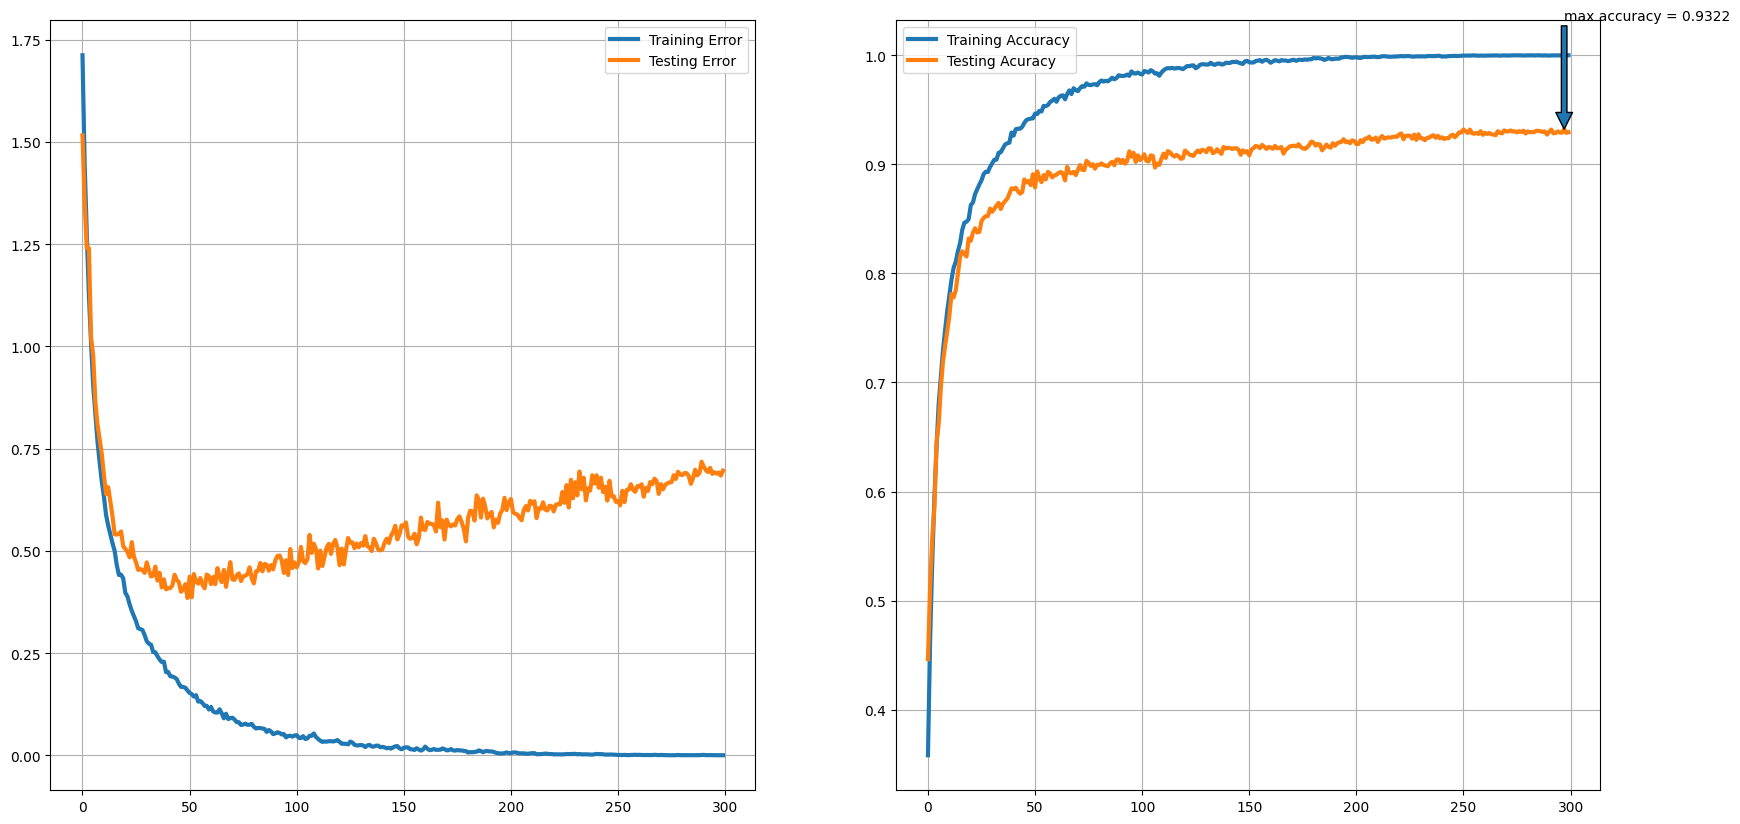

In [ ]:
# Get training and testing data
dataset = CIFAR10_Transformer(128)
trainLoader = dataset.getTrainingData()
testLoader = dataset.getTestingData()

# Create model and move to device
model = mini_project_model()
model = model.to(device)

# Train model on device
trainer = DataTrainer(model, device, 300, trainLoader, testLoader)
trainer.get_trainable_parameters()
trainer.check_if_model_under_budget(5000000)
trainer.train_model()
trainer.get_highest_accuracy()
trainer.plot_accuracy_and_loss_graphs()

## Test the best model over the dataset and print accuracy

In [ ]:

# Loading the best model
best_model = mini_project_model()
best_model.load_state_dict(torch.load("./mini_project_model.pt"))
best_model = best_model.to(device)

# Getting all test data with batch size 128
dataset = CIFAR10_Transformer(128)
testLoader = dataset.getTestingData()

# Evaluating accuracy byt testing over entire testing dataset
corrects = 0.0
best_model.eval()
for images, labels in testLoader:
    images = images.to(device)
    labels = labels.to(device)
    # Get output using model
    output = best_model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
    
print("Testing Accuracy for best model: ",corrects/len(testLoader.dataset))

Files already downloaded and verified
Files already downloaded and verified
Testing Accuracy for best model:  0.9322


##Plotting a Confusion matrix for the test data

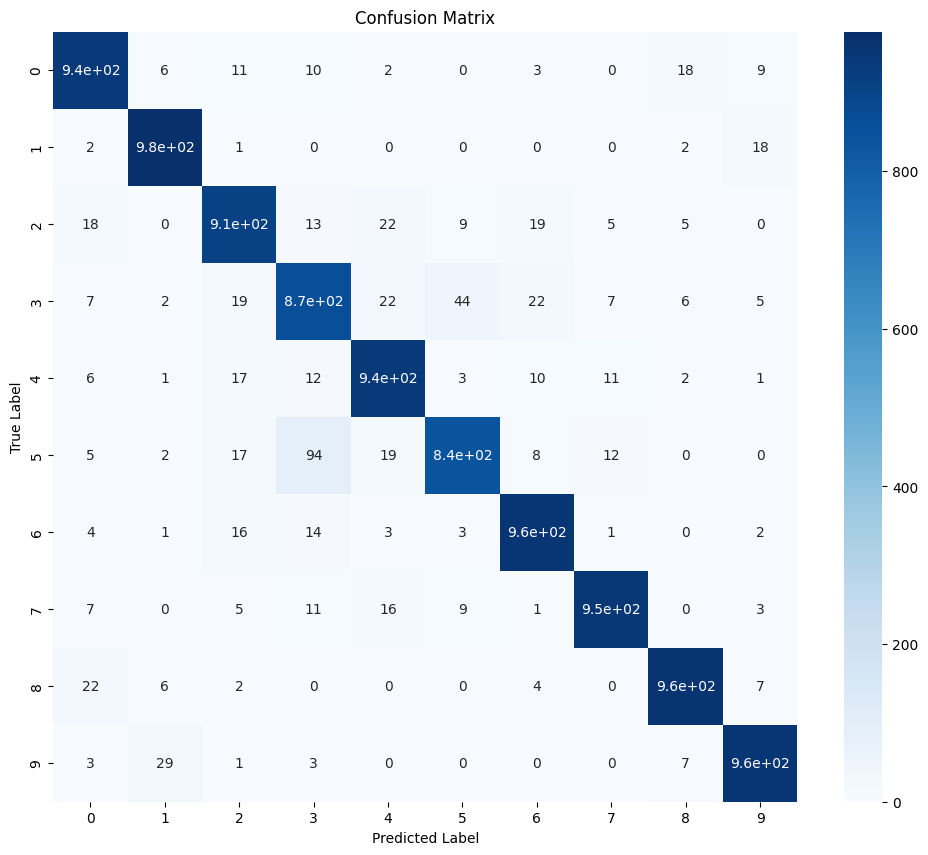

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to get the predictions for the test set
def get_predictions(model, testLoader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    return y_true, y_pred

# Get the predictions for the test set
y_true, y_pred = get_predictions(model, testLoader)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()